Random data generation:

In [1]:
import numpy as np

np.random.seed(4)
m = 60
w1, w2 = 0.1, 0.3
noise = 0.1

angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
X = np.empty((m, 3))
X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)

In [2]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

Calculating projection error:

In [4]:
X3D = pca.inverse_transform(X2D)

In [6]:
np.mean(np.sum(np.square(X3D - X), axis=1))  # the lost information is around 1%

0.010170337792848549

In [7]:
pca.components_

array([[-0.93636116, -0.29854881, -0.18465208],
       [ 0.34027485, -0.90119108, -0.2684542 ]])

In [8]:
pca.explained_variance_ratio_

array([0.84248607, 0.14631839])

In [10]:
1 - pca.explained_variance_ratio_.sum()  # 1.1% of the variance was lost

0.011195535570688975

In [122]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml('mnist_784', version=1)

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

/Users/Bartek/Desktop/Bartek/Programowanie/Portfolio/venv/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [123]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [124]:
d  # 154 dimensions explain at least 95% of the variance of the MNIST dataset

154

In [125]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

X_reduced.shape

(56000, 154)

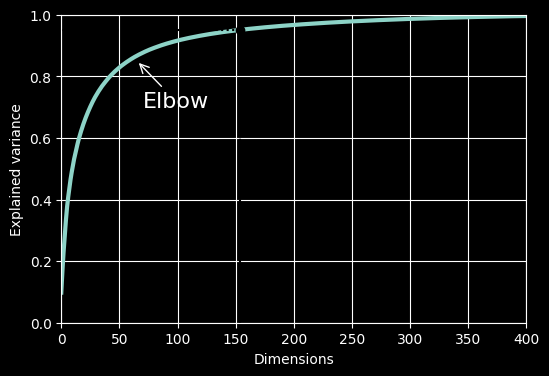

In [126]:
from matplotlib import pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained variance")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)
plt.show()

In [203]:
import pandas as pd


pca = PCA(n_components = 154)
X_reduced = pca.fit_transform(X_train)
X_recovered = pd.DataFrame(pca.inverse_transform(X_reduced))

In [206]:
import matplotlib as mpl


def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances.values]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

Text(0.5, 1.0, 'Compressed')

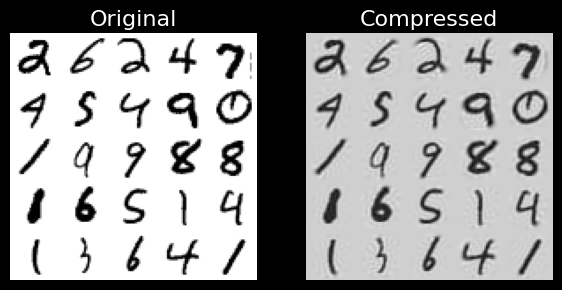

In [211]:
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2300])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2300])
plt.title("Compressed", fontsize=16)

Randomized PCA has smaller computational complexity than standard PCA: $O(m \times d^2) + O(d^3)$

Instead of:  $O(m \times n^2) + O(n^3)$



In [212]:
rnd_pca = PCA(n_components=154, svd_solver='randomized')
X_reduced = rnd_pca.fit_transform(X_train)

Incremental PCA can be used when working with huge amount of data that is exceeding memory capacity.

In [215]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)

for X_batch in np.array_split(X_train, n_batches):  # array_split divides the array into 100 batches
    inc_pca.partial_fit(X_batch)  # not fit()

X_reduced = inc_pca.transform(X_train)

/Users/Bartek/Desktop/Bartek/Programowanie/Portfolio/venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


Alternative: memmap from NumPy

In [216]:
filename = "my_mnist_data.data"
m, n = X_train.shape

X_mm = np.memmap(filename, dtype='float32', mode='write', shape=(m, n))
X_mm[:] = X_train

Deleting the X_mm object will trigger the finalization function which will allow the data to be saved on the disk

In [217]:
del X_mm

Next we can read the data from the disk and use them for model training

In [218]:
X_mm = np.memmap(filename, dtype="float32", mode="readonly", shape=(m, n))

batch_size = m // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=560, n_components=154)

In [219]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

Swiss roll dataset:

In [221]:
from sklearn.datasets import make_swiss_roll


X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [222]:
from sklearn.decomposition import KernelPCA

rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

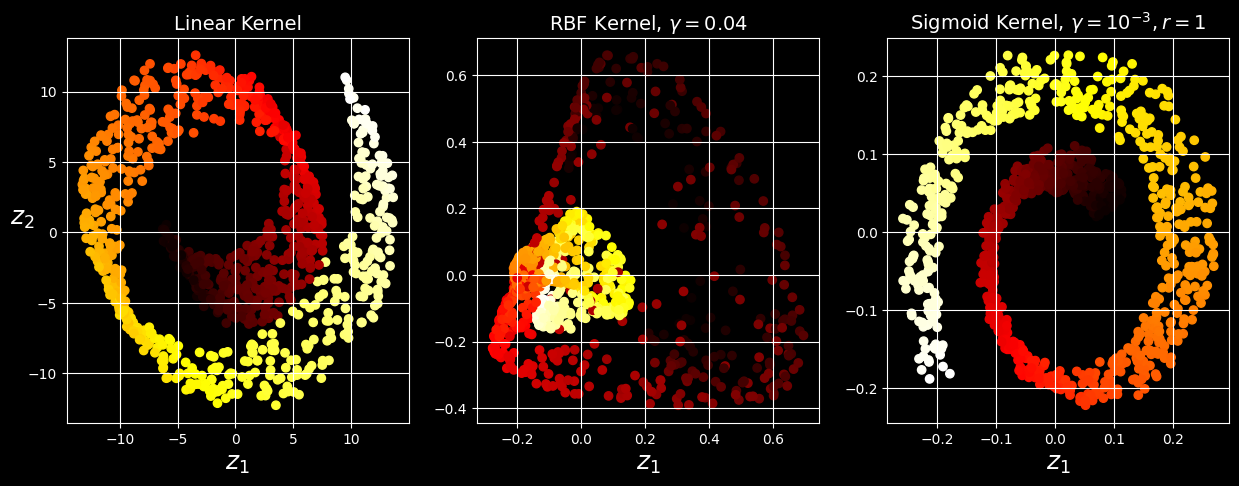

In [229]:
lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.04, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

y = t > 6.9

plt.figure(figsize=(15, 5))
for subplot, pca, title in ((131, lin_pca, "Linear Kernel"), (132, rbf_pca, "RBF Kernel, $\gamma=0.04$"), (133, sig_pca, "Sigmoid Kernel, $\gamma=10^{-3}, r=1$")):
    X_reduced = pca.fit_transform(X)
    if subplot == 132:
        X_reduced_rbf = X_reduced
    
    plt.subplot(subplot)
    #plt.plot(X_reduced[y, 0], X_reduced[y, 1], "gs")
    #plt.plot(X_reduced[~y, 0], X_reduced[~y, 1], "y^")
    plt.title(title, fontsize=14)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)
plt.show()

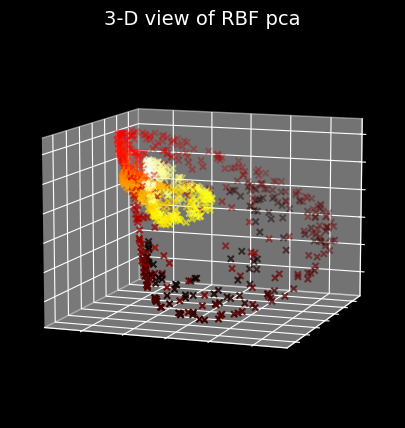

In [234]:
plt.figure(figsize=(6, 5))

X_inverse = rbf_pca.inverse_transform(X_reduced_rbf)

ax = plt.subplot(111, projection='3d')
ax.view_init(10, -70)
ax.scatter(X_inverse[:, 0], X_inverse[:, 1], X_inverse[:, 2], c=t, cmap=plt.cm.hot, marker="x")
ax.set_xlabel("")
ax.set_ylabel("")
ax.set_zlabel("")
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
plt.title('3-D view of RBF pca', fontsize=14)
plt.show()

Creating a pipeline of PCA compression with GridSearch for the best parameters.

In [235]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

clf = Pipeline([
    ('kpca', KernelPCA(n_components=2)),
    ('log_reg', LogisticRegression())
])

param_grid = [{
    'kpca__gamma': np.linspace(0.03, 0.05, 10),
    'kpca__kernel': ['rbf', 'sigmoid']
}]

grid_search = GridSearchCV(clf, param_grid, cv=5)
grid_search.fit(X, y)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('kpca', KernelPCA(n_components=2)),
                                       ('log_reg', LogisticRegression())]),
             param_grid=[{'kpca__gamma': array([0.03      , 0.03222222, 0.03444444, 0.03666667, 0.03888889,
       0.04111111, 0.04333333, 0.04555556, 0.04777778, 0.05      ]),
                          'kpca__kernel': ['rbf', 'sigmoid']}])

In [236]:
grid_search.best_params_

{'kpca__gamma': 0.04555555555555556, 'kpca__kernel': 'rbf'}

LLE - locally linear embedding - next Nonlinear Dimensionality Reduction (NLDR) technique.

This technique does not use projections. Instead, it measures distances from nearest neighbors and then searches for low-dimensional representation of those local relations.

In [238]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)
X_reduced = lle.fit_transform(X)

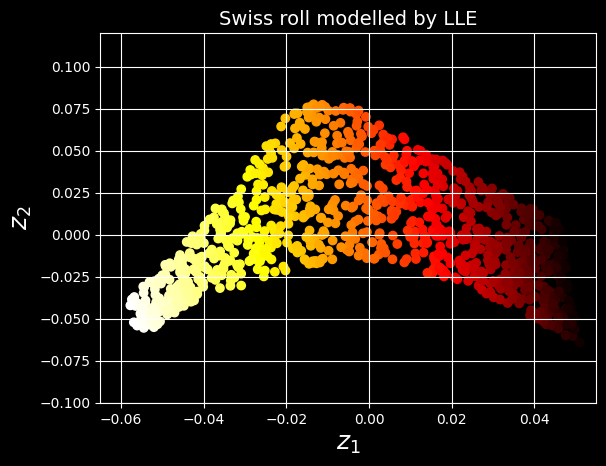

In [240]:
plt.title("Swiss roll modelled by LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)
plt.show()

In [272]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    # Przeskalujmy cechy wejściowe tak, aby mieściły się w zakresie od 0 do 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Tworzymy teraz listę współrzędnych dla dotychczas wyświetlanych cyfr na wykresie.
    # Udajemy, że jedna została już wygenerowana gdzieś daleko na wykresie
    # w celu uniknięcia instrukcji `if` w poniższej pętli
    neighbors = np.array([[10., 10.]])
    # Pozostała część kodu powinna być zrozumiała
    plt.figure(figsize=figsize)
    cmap = mpl.cm.jet
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(int(digit) / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()  # pobiera bieżące osie z bieżącego wykresu
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y.iloc[index])),
                         color=cmap(int(y.iloc[index]) / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images.iloc[index].values.reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

In [244]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'].iloc[idx]
y = mnist['target'].iloc[idx]

In [245]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
X_reduced = tsne.fit_transform(X)

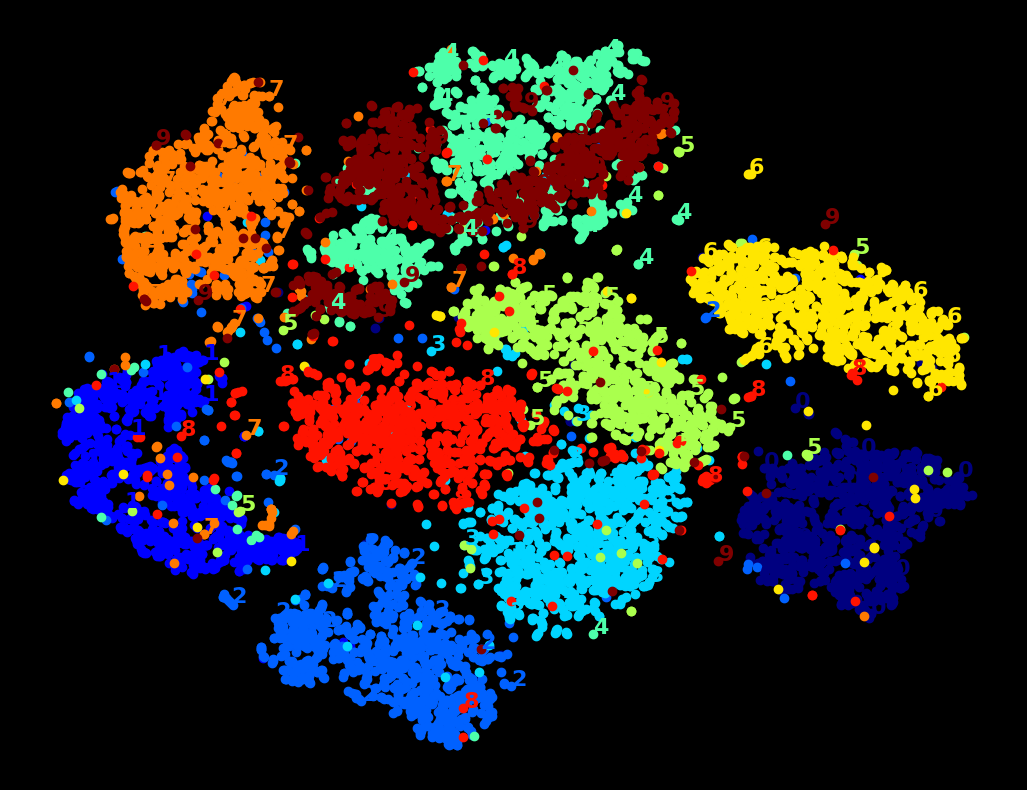

In [268]:
plot_digits(X_reduced, y)

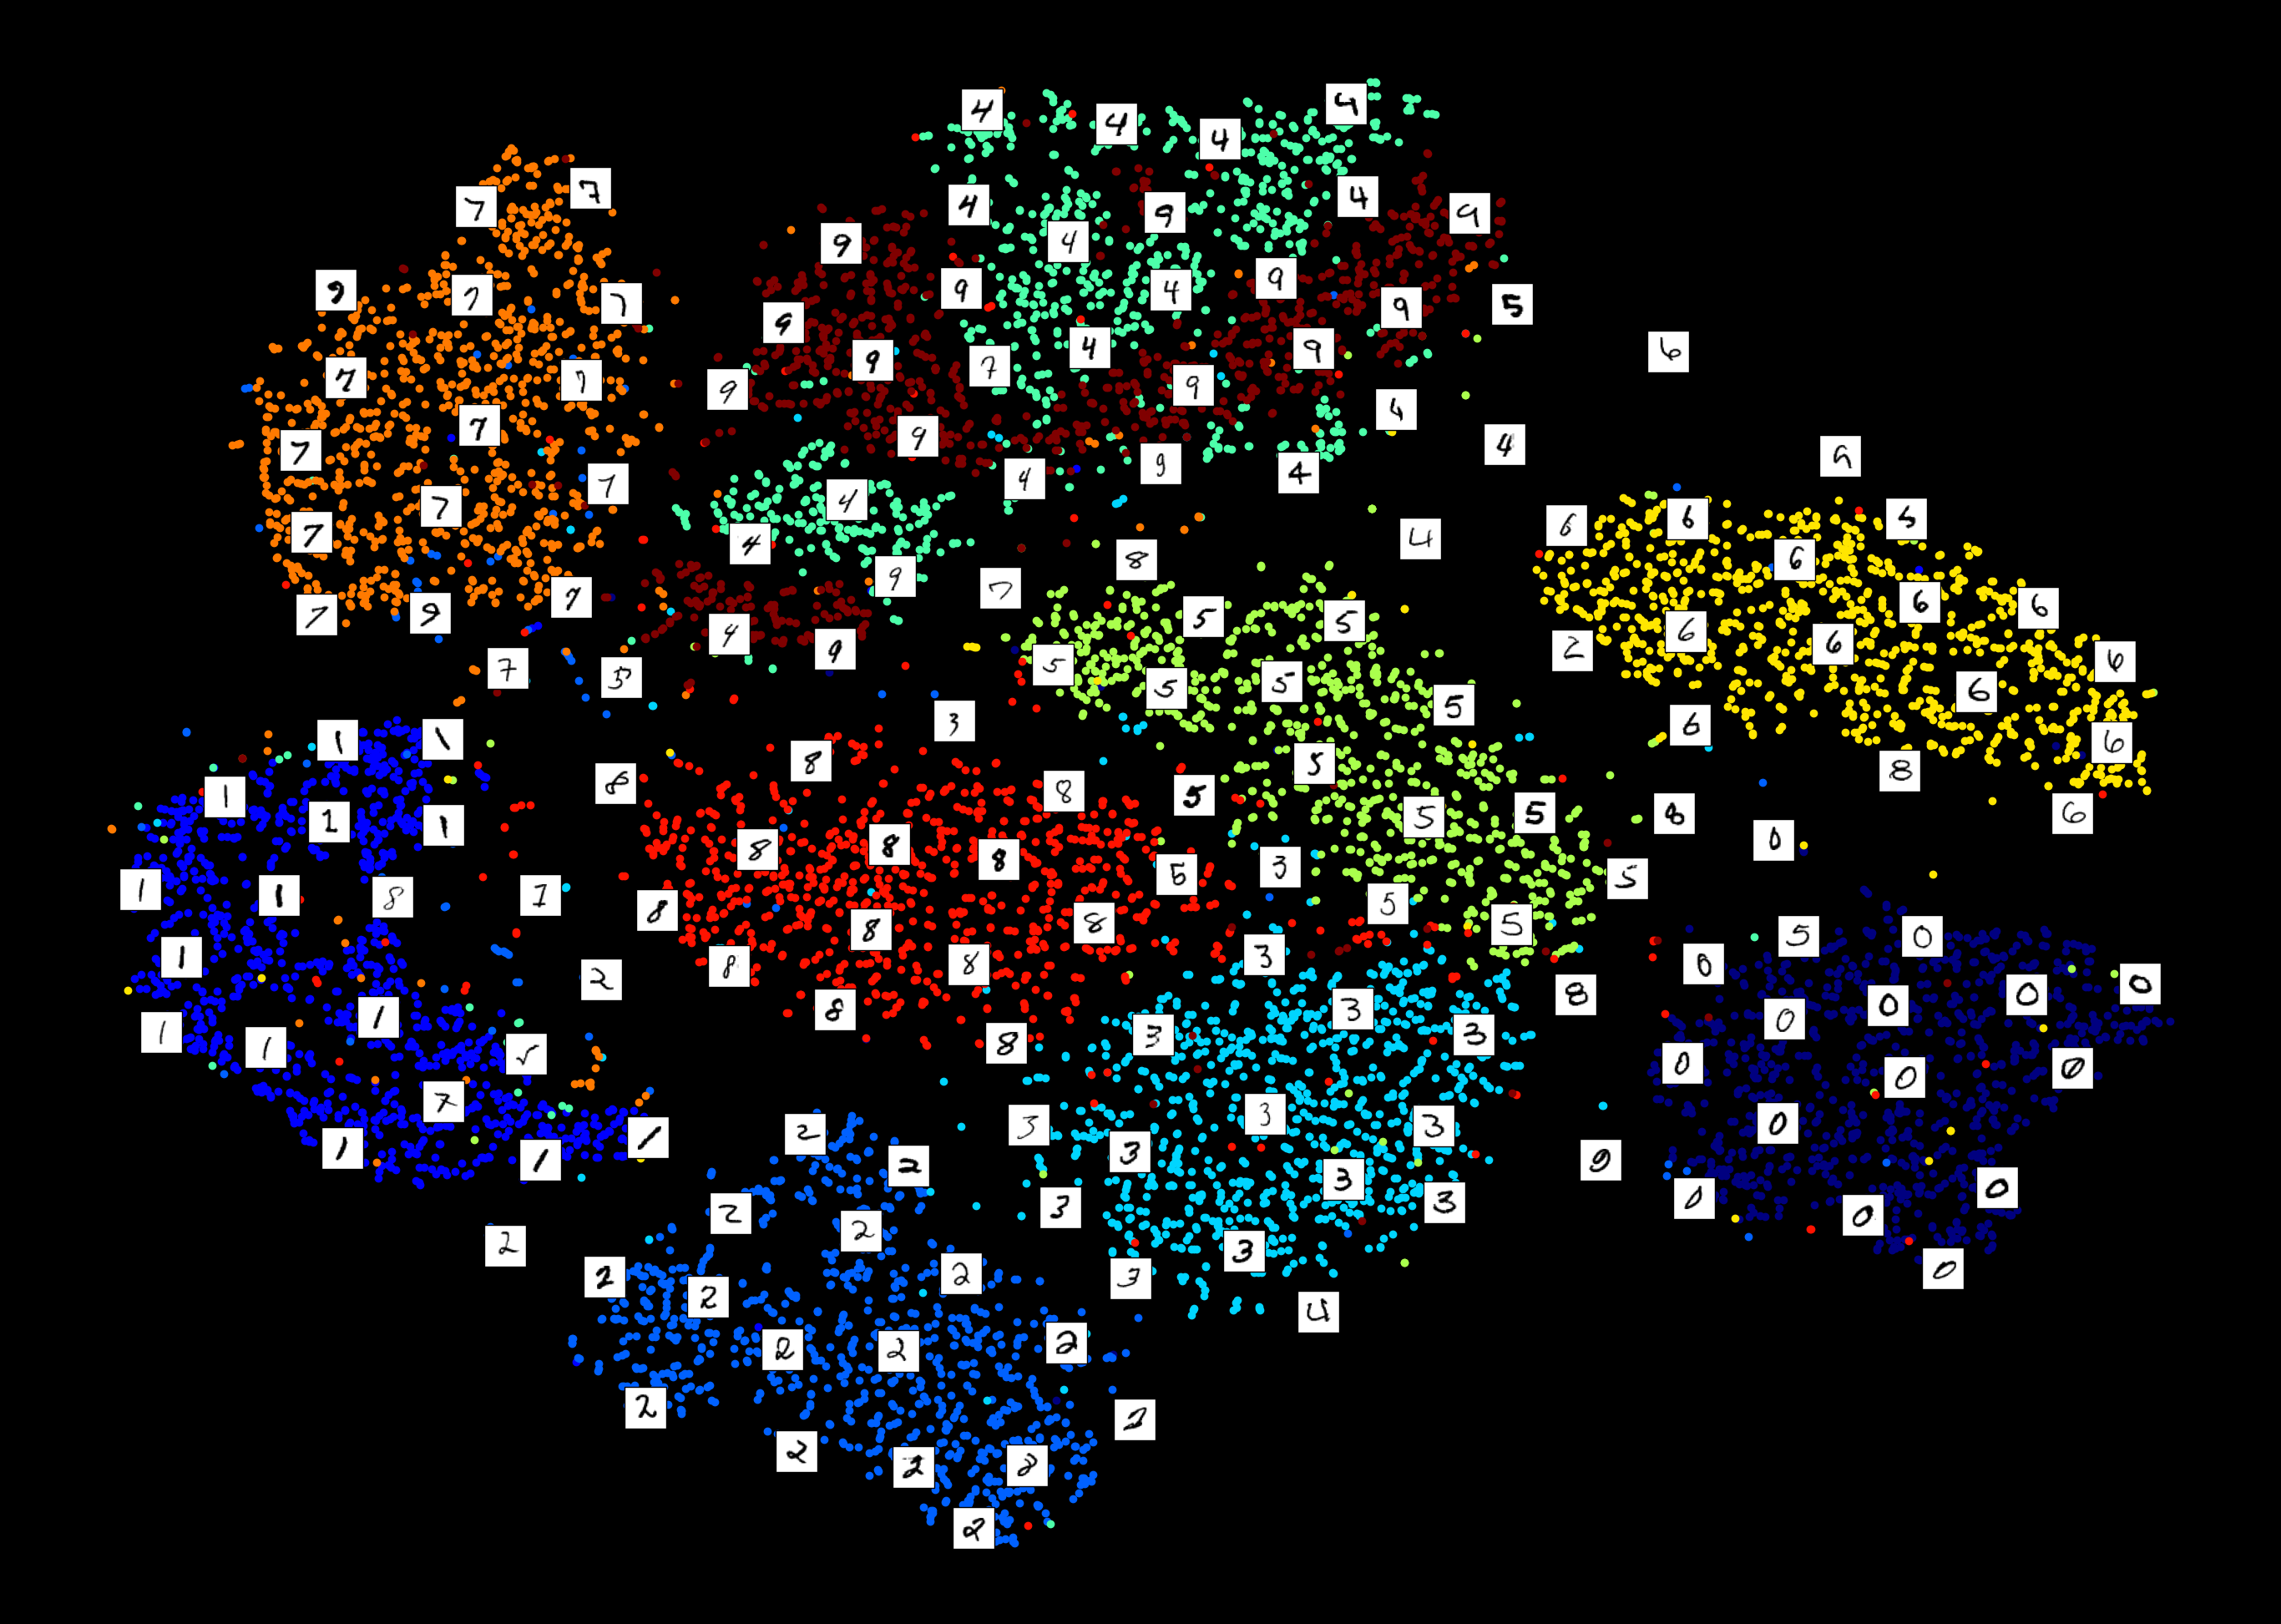

In [273]:
plot_digits(X_reduced, y, images=X, figsize=(35, 25))